## 같은 시간에 방송된 대표product를  exp_min, total, sales를 합쳐서 가져오기
* 같은 시간에 판매하며, 옵션이 다른 (예를 들면 여성용/남성용, 무이자/일시불, 10인용/6인용)도 하나로 합쳐서 각 각 노출시간 나오게 하기
* raw data에서 무형, total=0인 data drop 시키지 x

In [547]:
# !pip install plotly
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from tqdm.notebook import tqdm
# pd.set_option('display.max_rows', 100)

In [129]:
df = pd.read_excel('c:/bc/base_line_test.xlsx', header=0) # 무형, total_price가 0인 data 가져오기
df.p_name.loc[15751] = df.p_name.loc[15752]
# 위의 값은 '일시불 올리고 가스와이드그릴 프리미엄형'인데, 해당 방송에서 무이자만 exp_min을 가지고 있으므로 무이자로 바꿔준다.

### 같은 상품군에 있는 data를 같은 code로 나열하기

In [130]:
# copy만들어 사용. 왜냐면 후에 df와 merge 해야하므로!
tmp_df= df.copy()

tmp_df['HOUR']= tmp_df['HOUR'].replace(0, 24) # 나중에 for문 - 할 때 , 필요한 부분! 23시 다음 연속된 방송은 0시이기 때문에 오류
tmp_df['HOUR']= tmp_df['HOUR'].replace(1, 25)
tmp_df['HOUR']= tmp_df['HOUR'].replace(2, 26)

tmp_df = tmp_df.dropna(subset=['exp_min']) #없는 값은 있는 값이랑 중복이기에 drop처리/ 있는값은 계속 있다는 idea
# tmp_df

In [131]:
# 같은 날 같은 제품을 팔았을 경우 오류나서 hour 추가
df2 = tmp_df.groupby(['YEAR_DAY','p_group','m_code','p_code','p_name','HOUR']).agg({'exp_min':['sum'],'no':['min']})
df2.sort_index(ascending=False)

df2 = df2.groupby(level=[0,1,2,3,4,5]).sum()
df2.columns = ['exp_min','no'] #나중에 merge하기 편하게 변경
df2 = df2.reset_index() #multiindex라서 

df2['new_code'] = np.arange(0,len(df2.index)) #유일한 값 만들어주고, 번호 매기기

# df2

In [132]:
# df2_2 = df2.copy()

In [133]:
# hour가 다른 시간이지만, 같은 상품일 때! 그 전 상품이나 뒷 상품이 같은 제품일 경우는 code를 그 전의 값으로 가져옴
for idx in range(1, df2.shape[0]):
    if (df2.loc[idx, 'p_group'] == df2.loc[idx-1, 'p_group']) and (abs(df2.loc[idx, 'p_code'] - df2.loc[idx-1, 'p_code']) <= 1)\
        and (df2.loc[idx, 'p_name'] != df2.loc[idx-1, 'p_name']):
        df2.loc[idx, 'p_name'] = df2.loc[idx-1, 'p_name']
    
    if (df2.loc[idx, 'p_name'] == df2.loc[idx-1,'p_name']) and (abs(df2.loc[idx, 'HOUR'] - df2.loc[idx-1,'HOUR']) <= 1):
        df2.loc[idx, 'new_code'] = df2.loc[idx-1, 'new_code']

In [134]:
# # hour가 다른 시간이지만, 같은 상품일 때! 그 전 상품이나 뒷 상품이 같은 제품일 경우는 code를 그 전의 값으로 가져옴
# for idx in range(1, df2.shape[0]):
#     if (df2_2.loc[idx, 'p_group'] == df2_2.loc[idx-1, 'p_group']) and (abs(df2_2.loc[idx, 'p_code'] - df2_2.loc[idx-1, 'p_code']) <= 4)\
#         and (df2_2.loc[idx, 'p_name'] != df2_2.loc[idx-1, 'p_name']):
#         df2_2.loc[idx, 'p_name'] = df2_2.loc[idx-1, 'p_name']
    
#     if (df2_2.loc[idx, 'p_name'] == df2_2.loc[idx-1,'p_name']) and (abs(df2_2.loc[idx, 'HOUR'] - df2_2.loc[idx-1,'HOUR']) <= 1):
#         df2_2.loc[idx, 'new_code'] = df2_2.loc[idx-1, 'new_code']

In [135]:
# df_diff = pd.concat([df2,df2_2]).drop_duplicates(keep=False)

In [136]:
# pd.options.display.max_rows = None
# df2 == df2_2

# ------------------------------------------------------------------------------------

In [137]:
code_df= pd.merge(left=df, right=df2.iloc[:,[7,8]], how='left', on=['no']) #축소한 데이터와 원래 데이터 merge
# df2에서 생성한 new_code 컬럼을 합쳐주는 작업

In [138]:
code_df['new_code']= code_df['new_code'].fillna(method='ffill') #new_code 를 앞의 값으로 채우기
code_df

,broadcast,exp_min,m_code,p_code,p_name,p_group,unit_price,total_price,sales,YEAR,...,HOUR,MINUTE,SECOND,YEAR_DAY,DAY_NAME,DAY_NUM,code,p_group_code,no,new_code
0,2019-01-01 06:00:00,20.000000,100346,201072,테이트 남성 셀린니트3종,의류,39900,2099000.0,53.0,2019,...,6,0,0,2019-01-01,Tuesday,2,0,0,0,13.0
1,2019-01-01 06:00:00,NaN,100346,201079,테이트 여성 셀린니트3종,의류,39900,4371000.0,110.0,2019,...,6,0,0,2019-01-01,Tuesday,2,0,0,1,13.0
2,2019-01-01 06:20:00,20.000000,100346,201072,테이트 남성 셀린니트3종,의류,39900,3262000.0,82.0,2019,...,6,20,0,2019-01-01,Tuesday,2,0,0,2,13.0
3,2019-01-01 06:20:00,NaN,100346,201079,테이트 여성 셀린니트3종,의류,39900,6955000.0,174.0,2019,...,6,20,0,2019-01-01,Tuesday,2,0,0,3,13.0
4,2019-01-01 06:40:00,20.000000,100346,201072,테이트 남성 셀린니트3종,의류,39900,6672000.0,167.0,2019,...,6,40,0,2019-01-01,Tuesday,2,0,0,4,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38304,2019-12-31 00:20:00,20.000000,100073,200196,삼성화재 행복한파트너 주택화재보험(1912),무형,0,NaN,NaN,2019,...,0,20,0,2019-12-31,Tuesday,2,7187,9,38304,8734.0
38305,2019-12-31 00:40:00,20.000000,100073,200196,삼성화재 행복한파트너 주택화재보험(1912),무형,0,NaN,NaN,2019,...,0,40,0,2019-12-31,Tuesday,2,7187,9,38305,8734.0
38306,2019-12-31 01:00:00,20.000000,100073,200196,삼성화재 행복한파트너 주택화재보험(1912),무형,0,NaN,NaN,2019,...,1,0,0,2019-12-31,Tuesday,2,7187,9,38306,8734.0
38307,2019-12-31 01:20:00,20.000000,100490,201478,더케이 예다함 상조서비스(티포트),무형,0,NaN,NaN,2019,...,1,20,0,2019-12-31,Tuesday,2,7188,9,38307,8736.0


In [139]:
# code_df.to_csv('c:/bc/3_whole.csv', encoding='utf-8-sig',index=False)

## 데이터 sum하기

In [438]:
tmp_df = code_df.copy()
df3 = tmp_df.groupby(['new_code']).agg({'exp_min':['sum'],'unit_price':['min'], 'total_price':['sum'],'sales':['sum'],'no':['min']})
df3.columns = ['exp_min','unit_price','total_price','sales','no']
df3.reset_index()

sum_df= pd.merge(code_df.iloc[:,[0,2,3,4,5,9,10,11,12,13,14,15,16,17,19,20,21]],df3,on='no', how='right')
sum_df= sum_df[['broadcast','exp_min','m_code','p_code','p_name','p_group','unit_price','total_price','sales','YEAR','MONTH','DAY','HOUR','MINUTE','SECOND','YEAR_DAY','DAY_NAME','DAY_NUM','p_group_code','new_code','no']]

# sum_df

In [141]:
# sum_df.to_csv('c:/bc/3_summary.csv', encoding='utf-8-sig',index=False)

### 방송단위 병합 후 다음단계 진행 - sales & total_price로 판매량에 대한 평가지표 

In [439]:
# p_group == '무형'을 제거하기 위해서 그 리스트를 가져온다.

mh_list = []
for idx, value in enumerate(sum_df.p_group):
    if value == '무형':
        mh_list.append(idx)
len(mh_list)

358

In [440]:
# sum_df[sum_df.p_group == '무형']
sum_df.drop(mh_list, inplace=True)
sum_df.reset_index(drop=True,inplace=True)

In [463]:
sum_df = pd.merge(sum_df,pd.qcut(sum_df.sales,q=5,labels = ['a','b','c','d','e']).to_frame().rename(columns={'sales':'sales_level'}),left_index = True,right_index = True ,how='left')

In [471]:
fig = px.scatter(sum_df,x="sales",y="total_price",color="sales_level")
fig.show()

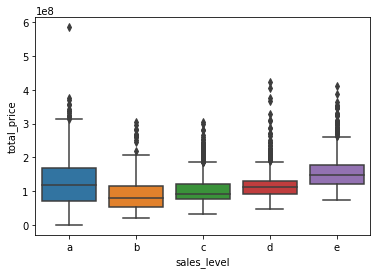

In [498]:
sns.boxplot(x='sales_level', y='total_price', data=sum_df)

In [535]:
def quantile_by_sales(level):

    q0 = np.quantile(sum_df[sum_df['sales_level'] == level].total_price, 0)
    q1 = np.quantile(sum_df[sum_df['sales_level'] == level].total_price, 0.25)
    q2 = np.quantile(sum_df[sum_df['sales_level'] == level].total_price, 0.5)
    q3 = np.quantile(sum_df[sum_df['sales_level'] == level].total_price, 0.75)
    q4 = np.quantile(sum_df[sum_df['sales_level'] == level].total_price, 1)
    
    IQR = (q3-q1)
    
    return {'min':q0,'q1':q1,'median':q2,'q3':q3,'max':q4,'iqr':IQR,'upper':q3+(1.5*IQR),'lower':q1-(1.5*IQR), 'mean':sum_df[sum_df['sales_level'] == level].total_price.mean()}

In [550]:
sum_df['grade'] = 0
for row, total_price in enumerate(tqdm(sum_df.total_price)):
    if total_price >= quantile_by_sales(sum_df.loc[row,'sales_level'])['upper']:
        sum_df.loc[row,'grade'] = 1
    elif quantile_by_sales(sum_df.loc[row,'sales_level'])['q3'] <= total_price < quantile_by_sales(sum_df.loc[row,'sales_level'])['upper']:
        sum_df.loc[row,'grade'] = 2
    elif quantile_by_sales(sum_df.loc[row,'sales_level'])['q1'] <= total_price < quantile_by_sales(sum_df.loc[row,'sales_level'])['q3']:
        sum_df.loc[row,'grade'] = 3
    else:
        sum_df.loc[row,'grade'] = 4

In [551]:
sum_df

,broadcast,exp_min,m_code,p_code,p_name,p_group,unit_price,total_price,sales,YEAR,...,MINUTE,SECOND,YEAR_DAY,DAY_NAME,DAY_NUM,p_group_code,new_code,no,sales_level,grade
0,2019-01-01 06:00:00,60.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,32696000.0,820.0,2019,...,0,0,2019-01-01,Tuesday,2,0,13.0,0,b,4
1,2019-01-01 07:00:00,60.0,100305,200974,오모떼 레이스 파운데이션 브라,속옷,59000,47878000.0,812.0,2019,...,0,0,2019-01-01,Tuesday,2,1,7.0,6,b,4
2,2019-01-01 08:00:00,60.0,100808,202377,CERINI by PAT 남성 소프트 기모 릴렉스팬츠,의류,59900,99736000.0,1665.0,2019,...,0,0,2019-01-01,Tuesday,2,0,16.0,9,d,3
3,2019-01-01 09:00:00,60.0,100816,202404,보코 리버시블 무스탕,의류,79000,90973000.0,1151.0,2019,...,0,0,2019-01-01,Tuesday,2,0,18.0,12,c,3
4,2019-01-01 10:00:00,60.0,100809,202395,CERINI by PAT 남성 풀패키지 기모니트 3종,의류,79900,259678000.0,3250.0,2019,...,0,0,2019-01-01,Tuesday,2,0,17.0,15,e,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6963,2019-12-31 18:20:00,60.0,100356,201134,마르엘라로사티 에코무스탕1종,의류,79000,201322000.0,2548.0,2019,...,20,0,2019-12-31,Tuesday,2,0,8745.0,38259,e,2
6964,2019-12-31 19:20:00,60.0,100594,201819,레스토닉 블루투스 LED 서랍 침대 슈퍼싱글,가구,599000,102360000.0,155.0,2019,...,20,0,2019-12-31,Tuesday,2,10,8723.0,38262,a,3
6965,2019-12-31 20:20:00,60.0,100501,201516,무이자 국내제조 노비타 뉴스파 비데 무료설치,생활용품,219000,191710000.0,762.0,2019,...,20,0,2019-12-31,Tuesday,2,6,8741.0,38271,b,2
6966,2019-12-31 21:20:00,60.0,100155,200556,일시불 LG전자 매직스페이스 냉장고,가전,1359000,222022000.0,157.0,2019,...,20,0,2019-12-31,Tuesday,2,5,8725.0,38283,a,2
